<a href="https://colab.research.google.com/github/BangachevKiril/RepresentationLearningTheory/blob/main/SigLIPModalityGapImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This code provides experiments for the modality gap in SigLIP following the [paper by Kiril Bangachev, Guy Bresler, Iliyas Noman, Yury Polyansnkiy](??)

The code is adpted from a [Notebook on SigLIP2 Experiments by Google DeepMind](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)

As the experiment does not require a massive amount of data, we choose to work with a subset of the ImageNET dataset. Specifically, we work with the [ILSVRC2012 validation dataset](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) which has 50 000 labelled images.

In [1]:
#@markdown # Environment setup
#@markdown **IMPORTANT NOTE**: Modern jax (>0.4) does not support the Colab TPU
#@markdown anymore, so don't select TPU runtime here. CPU and GPU work and are both fast enough.

# Install the right jax version for TPU/GPU/CPU
import os
if 'COLAB_TPU_ADDR' in os.environ:
  raise "TPU colab not supported."
elif 'NVIDIA_PRODUCT_NAME' in os.environ:
  !nvidia-smi
import jax
jax.devices()


# Get latest version of big_vision codebase.
!git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull --rebase --quiet
!pip -q install -r big_vision/big_vision/requirements.txt
# Gives us ~2x faster gsutil cp to get the model checkpoints.
!pip3 -q install --no-cache-dir -U crcmod

%cd big_vision


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import ml_collections

from google.colab.output import _publish as publish

Sun May 11 20:38:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Choose and load model, perform inference

In [2]:
# Pick your hero: (WHEN CHANGING THIS, RERUN IMAGE/TEXT EMBEDDING CELLS)
# Give this cell 1-3mins.

# VARIANT, RES = 'B/16', 224
# VARIANT, RES = 'B/16', 256
VARIANT, RES = 'B/16', 384
# VARIANT, RES = 'B/16', 512
# VARIANT, RES = 'L/16', 256
# VARIANT, RES = 'L/16', 384
# VARIANT, RES = 'So400m/14', 224
# VARIANT, RES = 'So400m/14', 384
# VARIANT, RES = 'B/16-i18n', 256
# VARIANT, RES = 'So400m/16-i18n', 256

CKPT, TXTVARIANT, EMBDIM, SEQLEN, VOCAB = {
    ('B/16', 224): ('webli_en_b16_224_63724782.npz', 'B', 768, 64, 32_000),
    ('B/16', 256): ('webli_en_b16_256_60500360.npz', 'B', 768, 64, 32_000),
    ('B/16', 384): ('webli_en_b16_384_68578854.npz', 'B', 768, 64, 32_000),
    ('B/16', 512): ('webli_en_b16_512_68580893.npz', 'B', 768, 64, 32_000),
    ('L/16', 256): ('webli_en_l16_256_60552751.npz', 'L', 1024, 64, 32_000),
    ('L/16', 384): ('webli_en_l16_384_63634585.npz', 'L', 1024, 64, 32_000),
    ('So400m/14', 224): ('webli_en_so400m_224_57633886.npz', 'So400m', 1152, 16, 32_000),
    ('So400m/14', 384): ('webli_en_so400m_384_58765454.npz', 'So400m', 1152, 64, 32_000),
    ('B/16-i18n', 256): ('webli_i18n_b16_256_66117334.npz', 'B', 768, 64, 250_000),
    ('So400m/16-i18n', 256): ('webli_i18n_so400m_16_256_78061115.npz', 'So400m', None, 64, 250_000),
}[VARIANT, RES]

# It is significantly faster to first copy the checkpoint (30s vs 8m30 for B and 1m vs ??? for L)
!test -f /tmp/{CKPT} || gsutil cp gs://big_vision/siglip/{CKPT} /tmp/

if VARIANT.endswith('-i18n'):
  VARIANT = VARIANT[:-len('-i18n')]

import big_vision.models.proj.image_text.two_towers as model_mod

model_cfg = ml_collections.ConfigDict()
model_cfg.image_model = 'vit'  # TODO(lbeyer): remove later, default
model_cfg.text_model = 'proj.image_text.text_transformer'  # TODO(lbeyer): remove later, default
model_cfg.image = dict(variant=VARIANT, pool_type='map')
model_cfg.text = dict(variant=TXTVARIANT, vocab_size=VOCAB)
model_cfg.out_dim = (None, EMBDIM)  # (image_out_dim, text_out_dim)
model_cfg.bias_init = -10.0
model_cfg.temperature_init = 10.0

model = model_mod.Model(**model_cfg)

# Using `init_params` is slower but will lead to `load` below performing sanity-checks.
# init_params = jax.jit(model.init, backend="cpu")(jax.random.PRNGKey(42), jnp.zeros([1, RES, RES, 3], jnp.float32), jnp.zeros([1, SEQLEN], jnp.int32))['params']
init_params = None  # Faster but bypasses loading sanity-checks.

params = model_mod.load(init_params, f'/tmp/{CKPT}', model_cfg)

Copying gs://big_vision/siglip/webli_en_b16_384_68578854.npz...
/ [1 files][721.4 MiB/721.4 MiB]   45.3 MiB/s                                   
Operation completed over 1 objects/721.4 MiB.                                    


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Embed Images

In [33]:
from PIL import Image
import os
import numpy as np
import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import time as time

In [34]:
pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
K = 50000
d = 768
embeddings_images = np.zeros((K, d))
imageidx = []
data_path = '/content/drive/My Drive/imagenetdata/ImageNetValidation/Images/ILSVRC2012_img_val/'
i = 0
start = time.time()
for file in os.listdir(data_path):
  if i % 10== 0:
    print(i, time.time()-start)
  namedata = file.split("_")[-1]
  index = namedata.split(".")[0]
  imageidx.append(int(index)-1)
  image = Image.open(os.path.join(data_path, file))
  image = image.resize((RES, RES))
  npimage = np.array(image)
  image = pp_img({'image': npimage})['image']
  image = np.expand_dims(image, axis=0)
  zimg,zt,out = model.apply({'params': params}, image, None)
  embeddings_images[i, :] = zimg.reshape(zimg.shape[-1])
  del image, zimg, zt, out
  i += 1
  if i >500:
    break

0 0.5778577327728271
10 6.285054683685303
20 11.941688776016235
30 21.719972610473633
40 34.451030015945435
50 47.183316707611084
60 60.02640628814697
70 72.55874943733215
80 85.7657036781311
90 97.85401034355164


ValueError: 'images' must have either 3 or 4 dimensions.

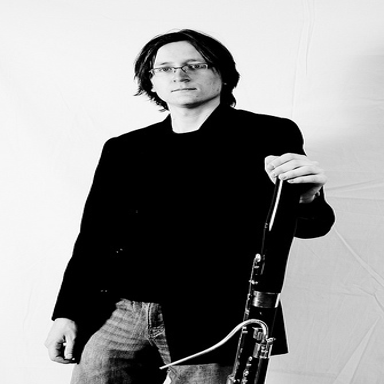

# Embed Text

In [19]:
labels_numberred = np.loadtxt( '/content/drive/My Drive/imagenetdata/ImageNetValidation/Labels.txt')
labels_numberred = labels_numberred.astype(int)

file_path = '/content/drive/My Drive/imagenetdata/ImageNetValidation/map_clsloc.txt'

with open(file_path, 'r') as file:
  map = file.readlines()
map = [line.strip() for line in map]
map = [x.split(" ") for x in map]
map = {int(line[1]):line[2] for line in map}
labels = [map[ell] for ell in labels_numberred]
labels = [word.replace("_", " ") for word in labels]

In [ ]:
TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')




In [20]:
from PIL import Image
import numpy as np

images_real = []
for i in range(len(images)):
  image = Image.fromarray(images[i])
  image = image.resize((RES, RES))
  images_real.append(np.array(image))

barracouta


array([[[ 95, 109, 118],
        [ 92, 107, 114],
        [ 93, 110, 117],
        ...,
        [101, 148, 178],
        [102, 149, 179],
        [104, 151, 181]],

       [[ 89, 103, 112],
        [ 86, 100, 109],
        [ 86, 102, 109],
        ...,
        [ 99, 145, 175],
        [ 99, 144, 174],
        [101, 146, 175]],

       [[ 88, 102, 111],
        [ 84,  98, 107],
        [ 83,  99, 107],
        ...,
        [ 99, 144, 173],
        [101, 144, 173],
        [105, 146, 176]],

       ...,

       [[187, 184, 167],
        [186, 183, 166],
        [185, 182, 166],
        ...,
        [172, 172, 163],
        [170, 171, 164],
        [172, 173, 167]],

       [[185, 182, 163],
        [181, 178, 160],
        [184, 181, 165],
        ...,
        [171, 171, 163],
        [171, 172, 163],
        [173, 175, 165]],

       [[192, 189, 170],
        [186, 183, 165],
        [188, 185, 170],
        ...,
        [166, 166, 157],
        [170, 171, 160],
        [172, 174, 161]]], dtype=uint8)
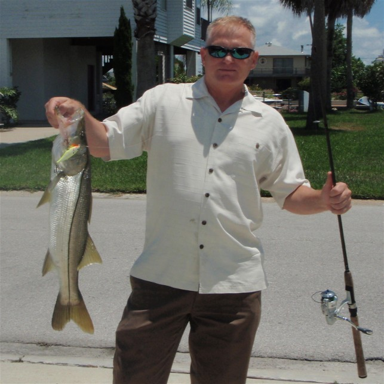

In [25]:
images = images_real
print(labels[imageidx[9]])
images[9]

In [ ]:
#@title Load and embed images

import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import PIL

pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
imgs = np.array([pp_img({'image': np.array(image)})['image'] for image in images])

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


In [ ]:
image_embeddings = []
for i in range(K):
  if i % 10 == 0:
    print(i)
  zimg,zt,out = model.apply({'params': params}, imgs[i:i+1], None)
  image_embeddings.append(zimg.reshape(zimg.shape[-1]))
  del out
  del zt
# with jax.disable_jit():
#   zimg, _, out = model.apply({'params': params}, imgs, None)
# print(imgs.shape, zimg.shape)

0
10
20
30
40


In [ ]:
image_embeddings[1].shape

(1024,)

In [ ]:
#@title Tokenize and embed texts
text_embeddings = []

TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')
txts = np.array([pp_txt({'text': text})['labels'] for text in labels])
txts.shape

(50, 64)

In [ ]:
for i in range(K):
  if i % 10 == 0:
    print(i)
  zi, ztext,out = model.apply({'params': params}, None, txts[i:i+1])
  text_embeddings.append(ztext.reshape(ztext.shape[-1]))
  del out

0
10
20
30
40


In [ ]:
image_embeddings = np.array(image_embeddings)
text_embeddings = np.array(text_embeddings)
text_embeddings.shape

(50, 1024)

In [ ]:
(text_embeddings @ image_embeddings.T)[:5,:5]

array([[ 0.00263561, -0.01872494, -0.01699198, -0.01898041, -0.0426564 ],
       [-0.03336725,  0.07944512, -0.02408459, -0.01270709,  0.00745103],
       [-0.03581281,  0.0073556 ,  0.06477004, -0.03747611, -0.03965563],
       [-0.07380158,  0.00401219, -0.05666231,  0.11627857, -0.06677845],
       [-0.08315592,  0.00507741, -0.06056623, -0.02215084,  0.12622549]],
      dtype=float32)

In [ ]:
gram = text_embeddings @ image_embeddings.T
min_diag, max_diag = np.min(gram.diagonal()), np.max(gram.diagonal())
print(f"Diagonal: min {min_diag:.7f} max {max_diag:.7f}")

min_off_diag = np.min(gram + 10 *np.eye(K))
max_off_diag = np.max(gram - 10 *np.eye(K))
print(f"Off-diagonal: min {min_off_diag:.7f} max {max_off_diag:.7f}")

Diagonal: min 0.0026356 max 0.1557684
Off-diagonal: min -0.1205138 max 0.1233631


Hmm this is weird since strongly positively correlated. Lets check what they are

In [ ]:
h = np.argmax(gram - 10 *np.eye(K))
(i,j) = (h//K, h%K)
print(labels[i])
print(labels[j])

crutch
crutch


array([[[ 76,  76,  76],
        [ 76,  76,  76],
        [ 76,  76,  76],
        ...,
        [141, 141, 141],
        [141, 141, 141],
        [141, 141, 141]],

       [[ 76,  76,  76],
        [ 76,  76,  76],
        [ 76,  76,  76],
        ...,
        [141, 141, 141],
        [141, 141, 141],
        [141, 141, 141]],

       [[ 76,  76,  76],
        [ 76,  76,  76],
        [ 76,  76,  76],
        ...,
        [142, 142, 142],
        [142, 142, 142],
        [142, 142, 142]],

       ...,

       [[ 79,  79,  79],
        [ 79,  79,  79],
        [ 79,  79,  79],
        ...,
        [139, 139, 139],
        [139, 139, 139],
        [139, 139, 139]],

       [[ 79,  79,  79],
        [ 79,  79,  79],
        [ 79,  79,  79],
        ...,
        [138, 138, 138],
        [138, 138, 138],
        [138, 138, 138]],

       [[ 79,  79,  79],
        [ 79,  79,  79],
        [ 79,  79,  79],
        ...,
        [138, 138, 138],
        [138, 138, 138],
        [138, 138, 138]]], dtype=uint8)
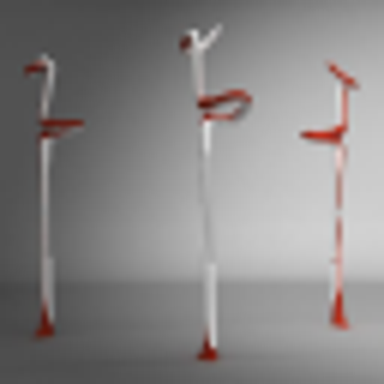

In [ ]:
images[i]

array([[[ 93,  59,   3],
        [ 93,  59,   3],
        [ 93,  59,   3],
        ...,
        [  3,   3,   1],
        [  3,   3,   1],
        [  3,   3,   1]],

       [[ 93,  59,   3],
        [ 93,  59,   3],
        [ 93,  59,   3],
        ...,
        [  3,   3,   1],
        [  3,   3,   1],
        [  3,   3,   1]],

       [[ 93,  59,   3],
        [ 93,  59,   3],
        [ 93,  59,   3],
        ...,
        [  3,   3,   1],
        [  3,   3,   1],
        [  3,   3,   1]],

       ...,

       [[ 19,   9,   3],
        [ 19,   9,   3],
        [ 20,   9,   3],
        ...,
        [211, 205, 205],
        [211, 205, 205],
        [211, 205, 205]],

       [[ 19,   9,   3],
        [ 19,   9,   3],
        [ 20,   9,   3],
        ...,
        [211, 205, 205],
        [211, 205, 205],
        [211, 205, 205]],

       [[ 19,   9,   3],
        [ 19,   9,   3],
        [ 20,   9,   3],
        ...,
        [210, 205, 205],
        [210, 205, 205],
        [210, 205, 205]]], dtype=uint8)
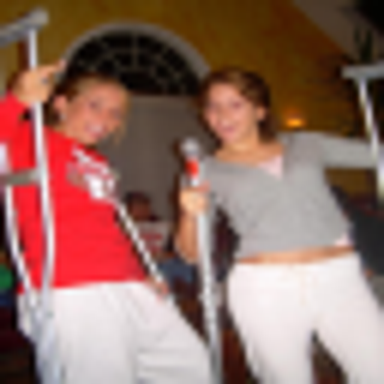

In [ ]:
images[j]

## Filtering Data for Better Performance

## Fit perceptron

In [ ]:
from sklearn.linear_model import Perceptron

In [ ]:
representations = np.concatenate([text_embeddings, image_embeddings])
modality = np.concatenate([-np.ones(K), np.ones(K)])

In [ ]:
classifier = Perceptron()
classifier.fit(representations,modality)

Perceptron()

In [ ]:
perceptron_parameters = classifier.get_params(deep = True)

In [ ]:
predicted = np.matmul(representations, classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_

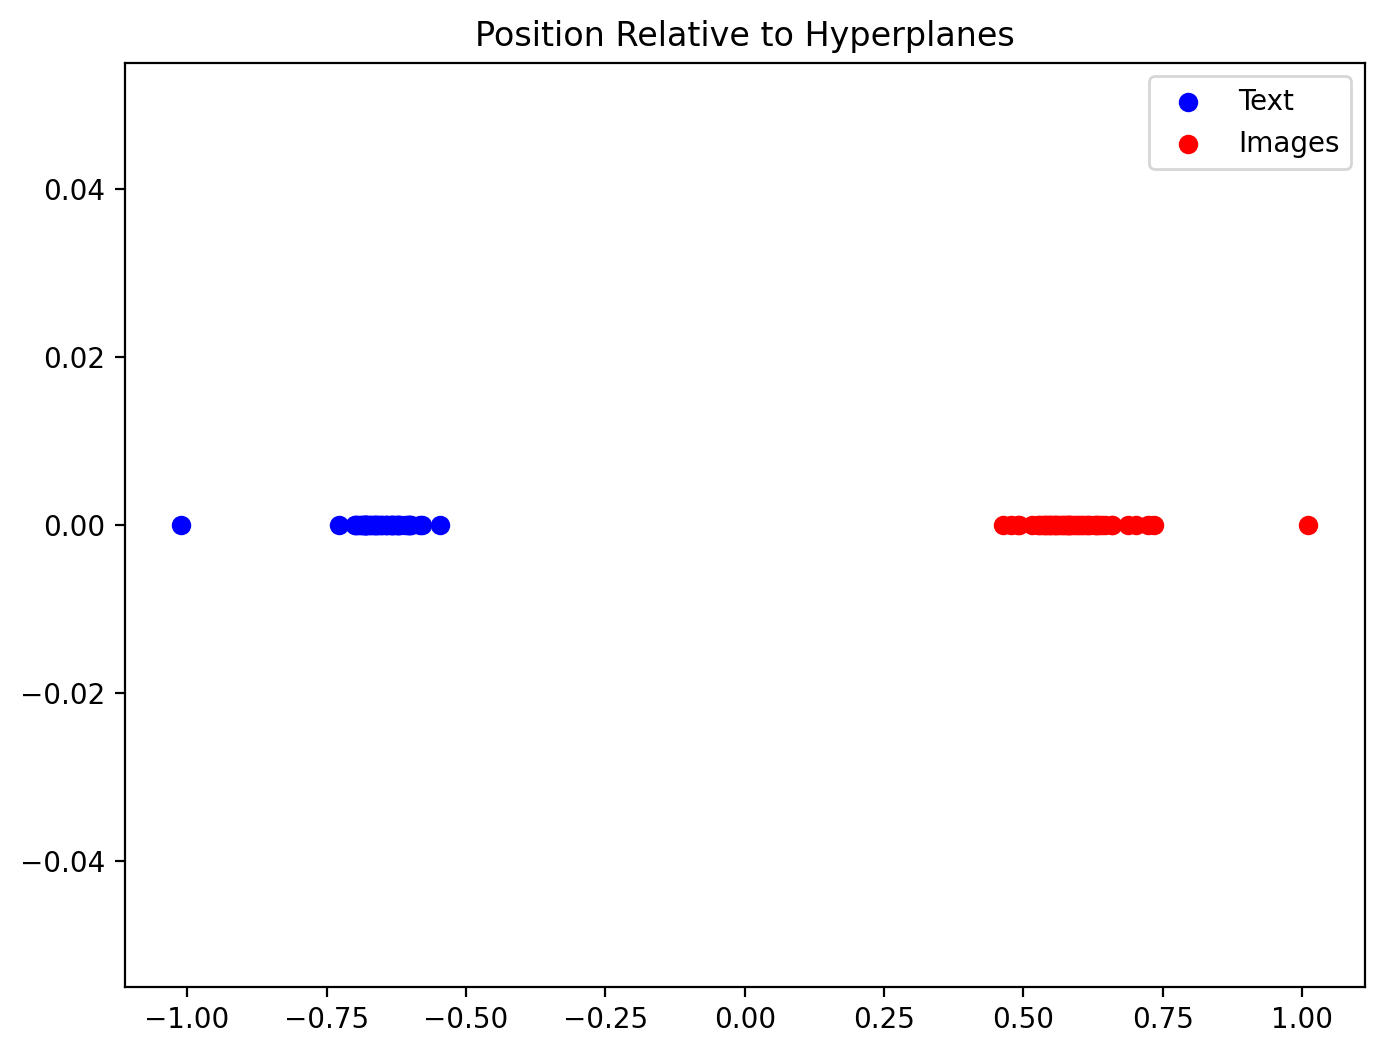

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plot class 1 data in blue
plt.scatter(predicted[:K], np.zeros_like(predicted[:K]), color='blue', label='Text')

# Plot class 2 data in red
plt.scatter(predicted[K:], np.zeros_like(predicted[K:]), color='red', label='Images')

# Customize the plot (optional)
plt.title('Position Relative to Hyperplanes')
plt.legend()

# Show the plot
plt.show()